In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.svm import SVC
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor

import warnings
warnings.filterwarnings('ignore')

## a. We want to make a regression model to predict the wear of the drive shaft. First, split the dataset in a train and test. Use the train set to plot the data in a suitable manner. 

In [42]:
# Split the dataset in a train and test.
shaft_data = pd.read_csv('shaft_radius.csv')
X = shaft_data['measurement_index'].values.reshape(-1,1)
y = shaft_data['shaft_radius']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.70, random_state = 2)

Text(0.5, 1.0, 'Shaft Radius Data')

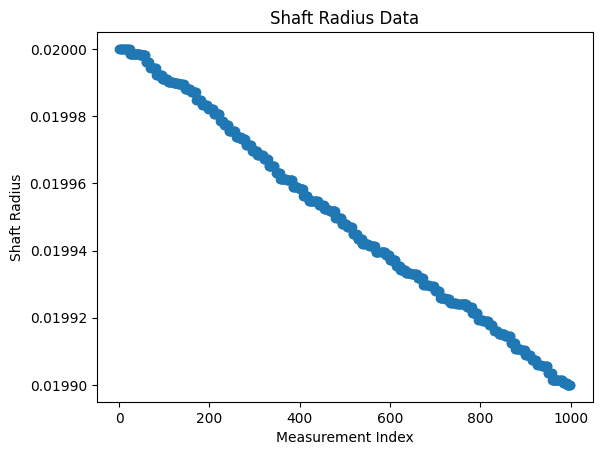

In [43]:
# Use the train set to plot the data. 
plt.scatter(X_train, y_train)
plt.xlabel('Measurement Index')
plt.ylabel('Shaft Radius')
plt.title('Shaft Radius Data')

# The plot seems pretty linear.

## b. Make a regression model to predict radius of the drive shaft based on the time that the drive shaft had been running. Explain why you chose this regression model.

In [53]:
def evaluate_model(model, X, y, k=5): 

  # Using K-Fold Cross-Validation for more robust evaluation
  # (reduces the risk of overfitting)
  kf = KFold(n_splits=k, shuffle=True, random_state=2)

  # Then initialize empty lists to store the metrics
  mse_test_list, mse_train_list, r2_test_list, r2_train_list = [], [], [], []

  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the model on the training fold
    model.fit(X_train, y_train)

    # Predict on training and testing folds
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate metrics for this fold, append them to the corresponding lists
    mse_test_list.append(mean_squared_error(y_test, y_test_pred))
    mse_train_list.append(mean_squared_error(y_train, y_train_pred))
    r2_test_list.append(r2_score(y_test, y_test_pred))
    r2_train_list.append(r2_score(y_train, y_train_pred))

    # Calculate avg. metrics
    avg_mse_test = np.mean(mse_test_list)
    avg_mse_train = np.mean(mse_train_list)
    avg_r2_test = np.mean(r2_test_list)
    avg_r2_train = np.mean(r2_train_list)

    # Print results
    print("\nK-Fold Cross-Validation Results (average over", k, "folds):")
    print(f"Average MSE (Test data): {avg_mse_test:.4f}")
    print(f"Average MSE (Train data): {avg_mse_train:.4f}")
    print(f"Average R2 Score (Test data): {avg_r2_test:.4f}")
    print(f"Average R2 Score (Train data): {avg_r2_train:.4f}")

    return {
        'avg_mse_test': avg_mse_test,
        'avg_mse_train': avg_mse_train,
        'avg_r2_test': avg_r2_test,
        'avg_r2_train': avg_r2_train
    }

    # Evaluate the model with MSE and R^2

    # Why these metrics?
    # Training Data R²: measures how well the model captures
    #                   variability in the training data.
    # Training Data MSE: assess how well your model fits
    #                    the training data.
    # Test Data R²: evaluates the predictive quality of
    #               your model on unseen data.
    # Test Data MSE: assess how well the model
    #                generalizes to new data.

In [54]:
# 1st approach: we use Linear Regression because of the linear pattern
# and continuous (quantitative) variables seen in the data.
linreg_model = LinearRegression()
linreg_model.fit(X, y)

# Print the intercept and slope
print("Intercept: ", linreg_model.intercept_)
print("Slope: ", linreg_model.coef_[0])
print(f'Linear Regression\'s Equation: {np.round(linreg_model.coef_[0], 8)}x + {linreg_model.intercept_}')

# Predict on training and test data using the linreg_model
y_train_pred = linreg_model.predict(X_train)
y_test_pred = linreg_model.predict(X_test)

Intercept:  0.020001192716625118
Slope:  -1.0332535513396363e-07
Linear Regression's Equation: -1e-07x + 0.020001192716625118


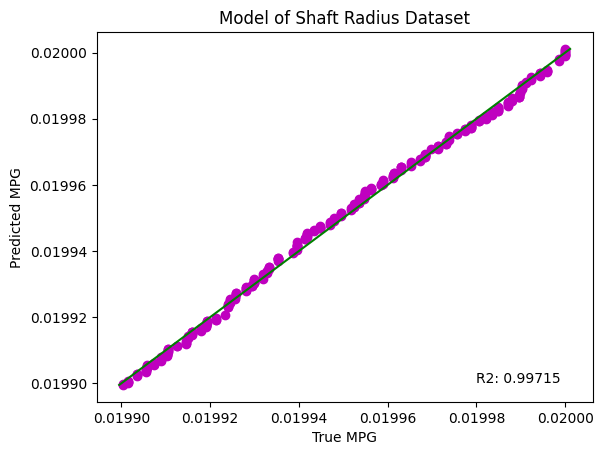


K-Fold Cross-Validation Results (average over 10 folds):
Average MSE (Test data): 0.0000
Average MSE (Train data): 0.0000
Average R2 Score (Test data): 0.9973
Average R2 Score (Train data): 0.9972


{'avg_mse_test': 2.406757044747417e-12,
 'avg_mse_train': 2.4588343742531335e-12,
 'avg_r2_test': 0.9973195122911038,
 'avg_r2_train': 0.9972411661547977}

In [89]:
# Evaluate the performance of linear regression model on the test data
y_min = min(np.min(y_test), np.min(y_test_pred))
y_max = max(np.max(y_test), np.max(y_test_pred))
plt.scatter(y_test, y_test_pred, c='m')
plt.plot((y_min, y_max), (y_min, y_max), c='g')
plt.title('Model of Shaft Radius Dataset')
plt.xlabel('True MPG')
plt.ylabel('Predicted MPG')
plt.gcf().text(0.85, 0.15, f'R2: {linreg_model.score(X_test, y_test):.5f}', fontsize=10, horizontalalignment='right')

plt.show()

# Then we can also evaluate the model with
# evaluate_model function
# (metrics = MSE and R^2)

evaluate_model(linreg_model, X, y, 10)


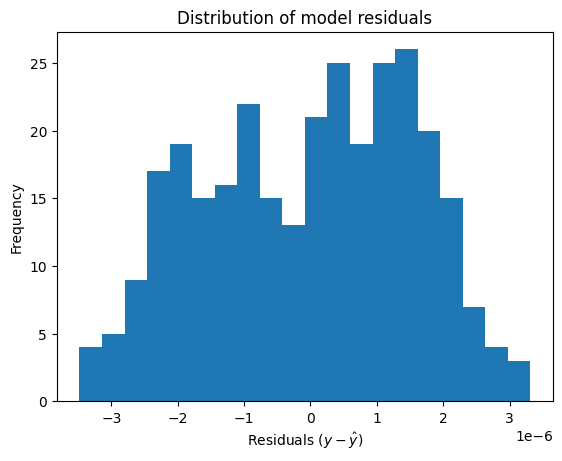

In [74]:
# Check whether the data's residuals are normally distributed
# to satisfy the conditions of linear regression
 
residuals = y_test - y_test_pred
plt.figure()
plt.hist(residuals, bins=20)
plt.title('Distribution of model residuals')
plt.xlabel('Residuals ($y-\hat y$)')
plt.ylabel('Frequency')
plt.show()

In [90]:
bagr = BaggingRegressor(base_estimator=DecisionTreeRegressor(),
                        random_state=42)

# Tune the parameters with GridSearchCV
param = {'n_estimators': [10, 50, 100, 200, 300]}
gcv_bagr = GridSearchCV(bagr,
                        param_grid = param,
                        cv=5, scoring='neg_mean_absolute_error')

gcv_bagr.fit(X_train, y_train)
best_bagr = gcv_bagr.best_estimator_
print('Best hyperparameter(s):', gcv_bagr.best_params_)
print('Best score:', gcv_bagr.best_score_)
print('Best model:', best_bagr)


Best hyperparameter(s): {'n_estimators': 200}
Best score: -1.6064918522005139e-07
Best model: BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=200,
                 random_state=42)


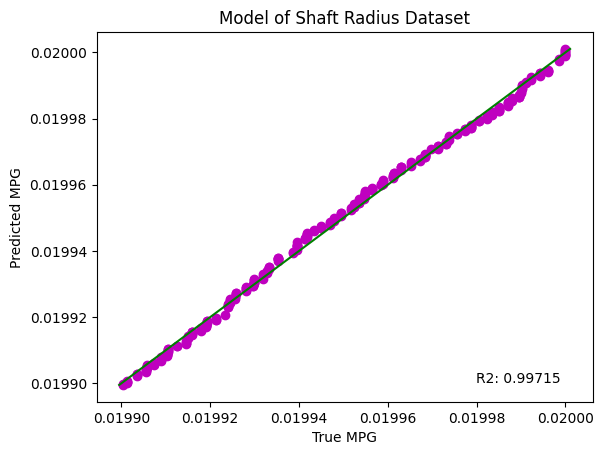


K-Fold Cross-Validation Results (average over 10 folds):
Average MSE (Test data): 0.0000
Average MSE (Train data): 0.0000
Average R2 Score (Test data): 0.9973
Average R2 Score (Train data): 0.9972


{'avg_mse_test': 2.406757044747417e-12,
 'avg_mse_train': 2.4588343742531335e-12,
 'avg_r2_test': 0.9973195122911038,
 'avg_r2_train': 0.9972411661547977}

In [91]:
# Predict on training and test data using the linreg_model
y_train_pred = linreg_model.predict(X_train)
y_test_pred = linreg_model.predict(X_test)
# Evaluate the performance of linear regression model on the test data
y_min = min(np.min(y_test), np.min(y_test_pred))
y_max = max(np.max(y_test), np.max(y_test_pred))
plt.scatter(y_test, y_test_pred, c='m')
plt.plot((y_min, y_max), (y_min, y_max), c='g')
plt.title('Model of Shaft Radius Dataset')
plt.xlabel('True MPG')
plt.ylabel('Predicted MPG')
plt.gcf().text(0.85, 0.15, f'R2: {linreg_model.score(X_test, y_test):.5f}', fontsize=10, horizontalalignment='right')

plt.show()

# Then we can also evaluate the model with
# evaluate_model function
# (metrics = MSE and R^2)

evaluate_model(linreg_model, X, y, 10)


In [52]:
rf = RandomForestRegressor(random_state=42)
gcv_rf = GridSearchCV(rf, param_grid={
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 2, 4, 6, 8, 10],
    'min_samples_split': [2, 10, 20, 40]},
    cv = 3, n_jobs = -1,
    verbose=3, scoring = 'neg_mean_absolute_error')

gcv_rf.fit(X_train, y_train)

best_rf = gcv_rf.best_estimator_

print('Best hyperparameter(s):', gcv_rf.best_params_)
print('Best score:', gcv_rf.best_score_)
print('Best model:', best_rf)

evaluate_model(best_rf, X, y)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
Best hyperparameter(s): {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best score: -1.978980538403644e-07
Best model: RandomForestRegressor(n_estimators=200, random_state=42)

K-Fold Cross-Validation Results (average over 5 folds):
Average MSE (Test data): 0.0000
Average MSE (Train data): 0.0000
Average R2 Score (Test data): 0.9999
Average R2 Score (Train data): 1.0000


{'avg_mse_test': 1.1096868661225676e-13,
 'avg_mse_train': 1.6717720037165563e-14,
 'avg_r2_test': 0.9998651869439314,
 'avg_r2_train': 0.9999816093939831}

In [8]:
# Why do we use MSE and R^2?
# MSE: To compare errors in the train and test data, and know whether the model is overfitting based on it (bias-variance trade-off).
# Pros: 
# Cons:

# R^2: To evaluate linear regression models’ fit.
# Pros: 
# Cons:

# Model's Reliability
# As shown above, we can see the MSE for both train and test data are incredibly small, which means the model
# fits the data very well. Moreover, the R2 score for both test and train data is approximately 1, which means
# the variance of the model is explained perfectly by the model.

# As a summary, we can safely tell that this is a good and reliable model to predict the radius of the drive shaft
# based on the time that the drive shaft had been running. Despite the dramatically low MSE values, we should not be
# worried too much about overfitting because this is a time-based data and has a clear linear pattern.

# What would you do to improve the model (for example, if you had more time)?
# 